In [4]:
import sys
sys.path.insert(0, "../")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from pathlib import Path
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import tifffile
from torch.utils.data import DataLoader
from src.loops.loops import validation_full_image, inference, inference_overlap
from src.utils.utils import rle2mask, IMAGE_SIZES, mask2rle
from src.transforms.transform import base_transform, valid_transform
from src.datasets.dataset import ImageDataset, SingleTiffDataset
from src.utils.metrics import dice_numpy
import gc
from tqdm import tqdm
import zarr
import cv2, zarr, tifffile
import rasterio

In [6]:
FACTOR = 6
CROP_SIZE= 1024 * 4 * FACTOR
IMG_TRAIN_SIZE = 1024 * FACTOR
BATCH_SIZE= 1
NUM_WORKERS = 0

In [7]:
df = pd.read_csv("/hdd/kaggle/hubmap/input_v2/train.csv").set_index("id", drop=True)
df_sub = pd.read_csv("/hdd/kaggle/hubmap/input_v2/sample_submission.csv")
input_path = Path("/hdd/kaggle/hubmap/input_v2")

In [1]:
!ls -l /hdd/kaggle/hubmap/input_v2/train

total 24278620
-rw-rw-r-- 1 trytolose trytolose       3713 Mar  9 20:12 0486052bb-anatomical-structure.json
-rw-rw-r-- 1 trytolose trytolose     277365 Mar  9 20:12 0486052bb.json
-rw-rw-r-- 1 trytolose trytolose  259124792 Mar  9 20:12 0486052bb.tiff
-rw-rw-r-- 1 trytolose trytolose        944 Mar  9 20:12 095bf7a1f-anatomical-structure.json
-rw-rw-r-- 1 trytolose trytolose    1271668 Mar  9 20:12 095bf7a1f.json
-rw-rw-r-- 1 trytolose trytolose 2517312665 Mar  9 20:12 095bf7a1f.tiff
-rw-rw-r-- 1 trytolose trytolose       2835 Mar  9 20:16 1e2425f28-anatomical-structure.json
-rw-rw-r-- 1 trytolose trytolose     780988 Mar  9 20:16 1e2425f28.json
-rw-rw-r-- 1 trytolose trytolose 1920094538 Mar  9 20:16 1e2425f28.tiff
-rw-rw-r-- 1 trytolose trytolose       3832 Mar  9 20:18 26dc41664-anatomical-structure.json
-rw-rw-r-- 1 trytolose trytolose     863936 Mar  9 20:18 26dc41664.json
-rw-rw-r-- 1 trytolose trytolose 2574845931 Mar  9 20:18 26dc41664.tiff
-rw-rw-r-- 1 trytolose trytolose     

In [5]:
img_id = "095bf7a1f"
img_path = Path("/hdd/kaggle/hubmap/input_v2/train") / f"{img_id}.tiff"
dataset = rasterio.open(img_path, num_threads="all_cpus")
# mask_main, mask_second = create_masks(img_id, rle, path)

h, w = dataset.height, dataset.width
if dataset.count == 3:
    image = dataset.read().transpose(1, 2, 0)
else:
    layers = []
    subdatasets = dataset.subdatasets
    if len(subdatasets) > 0:
        for i, subdataset in enumerate(subdatasets, 0):
            layers.append(rasterio.open(subdataset))
    image = np.stack([x.read().squeeze() for x in layers], axis=2)

/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [6]:
# image = layers[0].read().transpose(1, 2, 0)
# dataset.read().shape
# image = layers[0].read() #.transpose(1, 2, 0)

(1, 38160, 39000)

In [6]:
xx = np.stack([x.read().squeeze() for x in layers], axis=2)
xx.shape

(38160, 39000, 3)

In [18]:
for img_id, row in df.iterrows():
    img_path = Path("/hdd/kaggle/hubmap/input_v2/train") / f"{img_id}.tiff"
    dataset = rasterio.open(img_path, num_threads="all_cpus")
    print(img_id, dataset.count)

2f6ecfcdf 3
8242609fa 3
aaa6a05cc 3
cb2d976f4 3
b9a3865fc 3
b2dc8411c 3
0486052bb 3
e79de561c 3
095bf7a1f 1
54f2eec69 3
4ef6695ce 1
26dc41664 1
c68fe75ea 1
afa5e8098 3
1e2425f28 1


/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
img_path = Path(path) / f"{img_id}.tiff"
dataset = rasterio.open(img_path, num_threads="all_cpus")
mask_main, mask_second = create_masks(img_id, rle, path)

h, w = dataset.height, dataset.width
layers = []
if dataset.count != 3:
    subdatasets = dataset.subdatasets
    if len(subdatasets) > 0:
        for i, subdataset in enumerate(subdatasets, 0):
            layers.append(rasterio.open(subdataset))
else:
    layers.append(rasterio.open(img_path))


In [13]:
def read_image(image_id, path, scale=None, verbose=1):
    "Load images with ID from path"
    
#     image = tifffile.imread(path/f"train/{image_id}.tiff")
    
#     if len(image.shape) == 5:
#         image = image.squeeze().transpose(1, 2, 0)
#     elif image.shape[0] == 3:
#         image = image.transpose(1, 2, 0)
#     h, w = image.shape[:2]
#     if verbose:
#         print(f"[{image_id}] Image shape: {image.shape}")

    img_path = Path(path) / f"{image_id}.tiff"
    dataset = rasterio.open(img_path, num_threads="all_cpus")
    # mask_main, mask_second = create_masks(img_id, rle, path)

    h, w = dataset.height, dataset.width
    if dataset.count == 3:
        image = dataset.read().transpose(1, 2, 0)
    else:
        layers = []
        subdatasets = dataset.subdatasets
        if len(subdatasets) > 0:
            for i, subdataset in enumerate(subdatasets, 0):
                layers.append(rasterio.open(subdataset))
        image = np.stack([x.read().squeeze() for x in layers], axis=2)
    
    
#     if scale:
#         new_size = (image.shape[1] // scale, image.shape[0] // scale)
#         image = cv2.resize(image, new_size)
        
#         if verbose:
#             print(f"[{image_id}] Resized Image shape: {image.shape}")
#     h_new, w_new = image.shape[:2]
    return image #, h, w, h_new, w_new

In [7]:
# !rm -rf ../../input/zarr_train_orig
# !mkdir ../../input/zarr_train_orig
g_out = zarr.group(f'../../input/zarr_train_orig')
path = "/hdd/kaggle/hubmap/input_v2/train"
for img_id, row in tqdm(df.iterrows(), total=15):
#     image, h, w, h_new, w_new = read_image(img_id, input_path, scale=4)
    image = read_image(img_id, path, scale=4)
    h, w = image.shape[:2]
    print(image.shape)
    g_out[img_id] = image
    del image
    gc.collect()
    gc.collect()
    mask = rle2mask(row['encoding'], (w, h)).astype(np.uint8)
#     mask = cv2.resize(mask, (w_new, h_new))
    g_out[img_id+"_mask"] = mask
    del mask
    gc.collect()
    gc.collect()

  0%|          | 0/15 [00:00<?, ?it/s]/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(31278, 25794, 3)


  7%|▋         | 1/15 [00:23<05:33, 23.84s/it]

(31299, 44066, 3)


 13%|█▎        | 2/15 [01:07<07:38, 35.28s/it]

(18484, 13013, 3)


 20%|██        | 3/15 [01:15<04:33, 22.79s/it]

(34940, 49548, 3)


 27%|██▋       | 4/15 [02:05<06:12, 33.82s/it]

(31295, 40429, 3)


 33%|███▎      | 5/15 [02:46<06:01, 36.15s/it]

(14844, 31262, 3)


 40%|████      | 6/15 [02:59<04:16, 28.55s/it]

(25784, 34937, 3)


 47%|████▋     | 7/15 [03:26<03:42, 27.81s/it]

(16180, 27020, 3)


 53%|█████▎    | 8/15 [03:39<02:42, 23.23s/it]

(38160, 39000, 3)


 60%|██████    | 9/15 [04:25<03:02, 30.39s/it]

(30440, 22240, 3)


 67%|██████▋   | 10/15 [04:45<02:15, 27.11s/it]

(39960, 50680, 3)


 73%|███████▎  | 11/15 [05:42<02:25, 36.31s/it]

(38160, 42360, 3)


 80%|████████  | 12/15 [06:22<01:51, 37.24s/it]

(26840, 49780, 3)


 87%|████████▋ | 13/15 [07:02<01:16, 38.22s/it]

(36800, 43780, 3)


 93%|█████████▎| 14/15 [08:02<00:44, 44.79s/it]

(26780, 32220, 3)


100%|██████████| 15/15 [08:27<00:00, 33.86s/it]


## CREATE ZARR DATASET FOR PUBLIC TEST

In [8]:
df_sub

,id,predicted
0,2ec3f1bb9,NaN
1,3589adb90,NaN
2,d488c759a,NaN
3,aa05346ff,NaN
4,57512b7f1,NaN


In [14]:
# !rm -rf ../../input/zarr_train_orig
# !mkdir ../../input/zarr_train_orig
# g_out = zarr.group(f'../../input/zarr_train_orig')
path = "/hdd/kaggle/hubmap/input_v2/test"
# g_out = zarr.open("../../input/zarr_train_orig", mode="w")
for img_id, row in tqdm(df_sub.set_index("id").iterrows(), total=len(df_sub)):
#     image, h, w, h_new, w_new = read_image(img_id, input_path, scale=4)
    image = read_image(img_id, path, scale=4)
    h, w = image.shape[:2]
    print(image.shape)
    g_out[img_id] = image
    del image
    gc.collect()
    gc.collect()
#     mask = rle2mask(row['encoding'], (w, h)).astype(np.uint8)
#     mask = cv2.resize(mask, (w_new, h_new))
#     g_out[img_id+"_mask"] = mask
#     del mask
#     gc.collect()
#     gc.collect()

  0%|          | 0/5 [00:00<?, ?it/s]/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(23990, 47723, 3)


 20%|██        | 1/5 [00:23<01:35, 23.84s/it]

(29433, 22165, 3)


 40%|████      | 2/5 [00:36<00:51, 17.26s/it]

(46660, 29020, 3)


 60%|██████    | 3/5 [01:10<00:49, 24.96s/it]

(30720, 47340, 3)


 80%|████████  | 4/5 [01:39<00:26, 26.54s/it]

(33240, 43160, 3)


100%|██████████| 5/5 [02:03<00:00, 24.73s/it]


In [15]:
df_pseudo = pd.read_csv("public_predicts/924lb.csv").set_index('id')
g_out = zarr.open("../../input/zarr_train_orig", mode="r+")
h, w = g_out["aa05346ff"].shape[:2]
mask = rle2mask(df_pseudo.loc['aa05346ff', 'predicted'], (w, h)).astype(np.uint8)
g_out["aa05346ff_mask"] = mask

In [3]:
!ls public_predicts/blend.csv

public_predicts/blend.csv


In [10]:
df_blend.index

Index(['aa05346ff', '2ec3f1bb9', '3589adb90', 'd488c759a', '57512b7f1'], dtype='object', name='id')

In [8]:
df_blend = pd.read_csv("public_predicts/blend.csv").set_index('id')
g_out = zarr.open("../../input/zarr_train_orig", mode="r+")
for idx, row in df_blend.iterrows():

    h, w = g_out[idx].shape[:2]
    mask = rle2mask(row['predicted'], (w, h)).astype(np.uint8)
    g_out[f"{idx}_mask"] = mask

/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you 

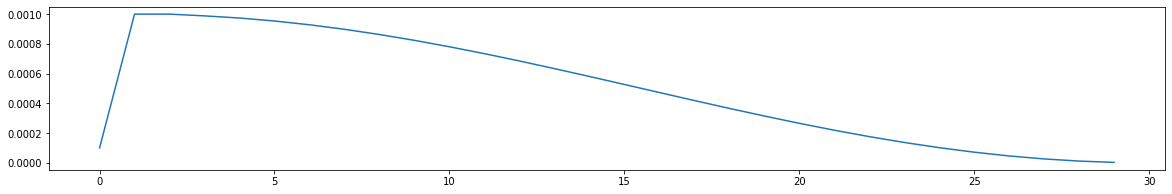

In [11]:
from warmup_scheduler import GradualWarmupScheduler
import torch
from torch import optim
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

init_lr = 1e-4
warmup_epo = 1
cosine_epo = 29
n_epochs = warmup_epo + cosine_epo
m = smp.Unet("resnet34")
optimizer = optim.Adam(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_warmup.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
# rcParams['figure.figsize'] = 20,3
plt.figure(figsize=(20, 3))
plt.plot(lrs)

In [6]:
import numpy as np

In [10]:
!ls -l ../../input/calc_coords

total 488
-rw-rw-r-- 1 trytolose trytolose 193173 Apr 11 22:52 train_fold0_crop_1024_img_1024_step_512.csv
-rw-rw-r-- 1 trytolose trytolose 193173 Apr 10 16:21 train_fold0_crop_1024_img_256_step_1024.csv
-rw-rw-r-- 1 trytolose trytolose  47977 Apr 11 22:54 valid_fold0_crop_1024_img_1024_step_1024.csv
-rw-rw-r-- 1 trytolose trytolose  47977 Apr 10 16:22 valid_fold0_crop_1024_img_256_step_1024.csv
-rw-rw-r-- 1 trytolose trytolose   6969 Apr 10 17:29 valid_fold0_crop_16384_img_4096_step_4096.csv
